# DEA Intertidal Elevation

This notebook demonstrates how to run and customise a DEA Intertidal Elevation analysis.

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides

from intertidal.io import (
    load_data,
    load_topobathy_mask,
    prepare_for_export,
)
from intertidal.elevation import (
    ds_to_flat,
    pixel_rolling_median,
    pixel_dem,
    pixel_dem_debug,
    pixel_uncertainty,
    flat_to_ds,
    clean_edge_pixels,
    elevation,
)
from intertidal.extents import load_connectivity_mask

## Setup


### Set analysis parameters

In [4]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
min_freq = 0.01  # Minimum wetness freq required for pixel to be included in analysis
max_freq = 0.99  # Maximum wetness freq required for pixel to be included in analysis
min_correlation = 0.15  # Minimum correlation between water index and tide height 
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis 
tide_model_dir = "/gdata1/data/tide_models_clipped"

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [5]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

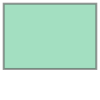

In [6]:
# Set study area to load from file
study_area = "pointstuart"

# Read file, select study area and convert to geom
studyarea_gdf = gpd.read_file(
    "data/raw/intertidal_development_polygons.geojson"
).set_index("id")
geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
geom

##### Option 3: load study area using interactive map

In [7]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Load data

In [8]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds, _, _ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36173 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36173/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36173/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42183,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36173/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:35389,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/37593/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:43701,


<xarray.Dataset> Size: 84MB
Dimensions:      (time: 303, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2019-01-07T01:16:28.775870 ... 202...
  * y            (y) float64 2kB -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 3kB -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 84MB dask.array<chunksize=(1, 219, 317), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 5.82 s, sys: 542 ms, total: 6.37 s
Wall time: 1min 13s


<xarray.Dataset> Size: 84MB
Dimensions:      (time: 303, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2019-01-07T01:16:28.775870 ... 202...
  * y            (y) float64 2kB -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 3kB -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 4B 3577
Data variables:
    ndwi         (time, y, x) float32 84MB 0.3482 0.3449 ... -0.08957 -0.092
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional masks
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [9]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product="ga_ausbathytopo250m_2023",
    resampling="bilinear",
    min_threshold=-15,
    mask_filters=[("dilation", 25)],
)

Generate a coastal mask, based on the connectivity of each pixel to the ocean.
Coastal pixels are identified by calculating "least-cost" distances from ocean weighted by elevation, where low, flat areas of terrain are assigned lower weights than high, steep pixels. 
This produces a coastal mask that extends further inland in low-lying coastal areas.

In [10]:
# Generate coastal connectivity mask to exclude non-tidal areas
coastal_mask, _ = load_connectivity_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox,
    product='ga_srtm_dem1sv1_0',
    elevation_band='dem_h',
    resampling='bilinear',
    buffer=20000,
    max_threshold=100,
)

## Pixel-based tides

In [11]:
# Model tides into every pixel in the three-dimensional (x, y, time)
# satellite dataset. If `model` is "ensemble" this generate optimised
# tide modelling by combining the best local tide models.
tide_m, _ = pixel_tides(
        ds=satellite_ds,
        model=tide_model,
        directory=tide_model_dir,
    )

Creating reduced resolution 5000 x 5000 metre tide modelling array
Running ensemble tide modelling
Modelling tides using FES2014, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10, FES2012, TPXO8-atlas-v1 in parallel


100%|██████████| 35/35 [00:22<00:00,  1.53it/s]


Interpolating model rankings using IDW interpolation 
Combining models into single ensemble model
Reprojecting tides into original array


In [12]:
# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery
satellite_ds["tide_m"] = tide_m.where(
    ~satellite_ds.to_array().isel(variable=0).isnull().drop("variable")
)

## Pixel-based DEM creation

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

<div class="alert alert-info">

**Note:** For Australia, we pass in a custom `valid_mask` to constrain the analysis to probable coastal pixels. 
This is optional, and can be skipped (at the expense of slightly less clean outputs and longer runtimes) by commenting out `valid_mask=...`.

</div>

In [13]:
%%time
flat_ds, freq, corr = ds_to_flat(
    satellite_ds,
    min_freq=min_freq,
    max_freq=max_freq,
    min_correlation=min_correlation,
    valid_mask=topobathy_mask & coastal_mask,
)

Reducing analysed pixels from 69423 to 43276 (62.34%)
CPU times: user 885 ms, sys: 515 ms, total: 1.4 s
Wall time: 1.36 s


### Pixel-wise rolling median
This function performs a rolling median calculation along the tide heights of our satellite images. 
It breaks our tide range into `windows_n` individual rolling windows, each of which covers `windows_prop_tide` of the full tidal range. 
For each window, the function returns the median of all tide heights and NDWI index values within the window, and returns an array with a new "interval" dimension that summarises these values from low to high tide.

More windows (e.g. `windows_n=100`) produces detailed elevation maps that can capture small differences in intertidal morphology - at the expense of slower run times.
Fewer windows (e.g. `windows_n=50`) will run faster, but produce less smooth, less detailed elevation maps.

In [14]:
%%time
interval_ds = pixel_rolling_median(
    flat_ds,
    windows_n=50,
    window_prop_tide=0.15,
    max_workers=None,
    min_count=5,
)

  0%|          | 0/55 [00:00<?, ?it/s]

CPU times: user 5.47 s, sys: 12.1 s, total: 17.6 s
Wall time: 27.1 s


### Model intertidal elevation and uncertainty

Test our workflow by plotting an example elevation extraction for a single pixel:

In [15]:
# x, y = -1455867.2,-2277114.2
# interval_pixel, interval_smoothed_pixel = pixel_dem_debug(
#     x,
#     y,
#     flat_ds,
#     interval_ds, 
#     interp_intervals=200,
#     smooth_radius=20,
#     min_periods=5,
#     # plot_style="season"
# )

Now model our full elevation raster:

In [16]:
# Model elevation
flat_dem = pixel_dem(
    interval_ds,
    ndwi_thresh=ndwi_thresh,
    interp_intervals=200,
    smooth_radius=20,
    min_periods=5,
)

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


In [17]:
# Model uncertainty
low, high, uncertainty, misclassified = pixel_uncertainty(
    flat_ds, flat_dem, ndwi_thresh, method="mad"
)

# Add arrays to dataset
flat_dem[["elevation_low", "elevation_high", "elevation_uncertainty"]] = (
    low,
    high,
    uncertainty,
)

## Unstack outputs and export

In [18]:
# Combine QA layers with elevation layers
flat_combined = xr.combine_by_coords(
    [flat_dem,  # DEM data
     freq,  # Frequency
     corr,  # Correlation
    ],
)

# Unstack elevation and uncertainty layers back into their original 
# spatial dimensions
ds = flat_to_ds(flat_combined, satellite_ds)

# Clean upper edge of intertidal zone in elevation layers 
# (likely to be inaccurate edge pixels)
elevation_bands = [d for d in ds.data_vars if "elevation" in d]
ds[elevation_bands] = clean_edge_pixels(ds[elevation_bands])


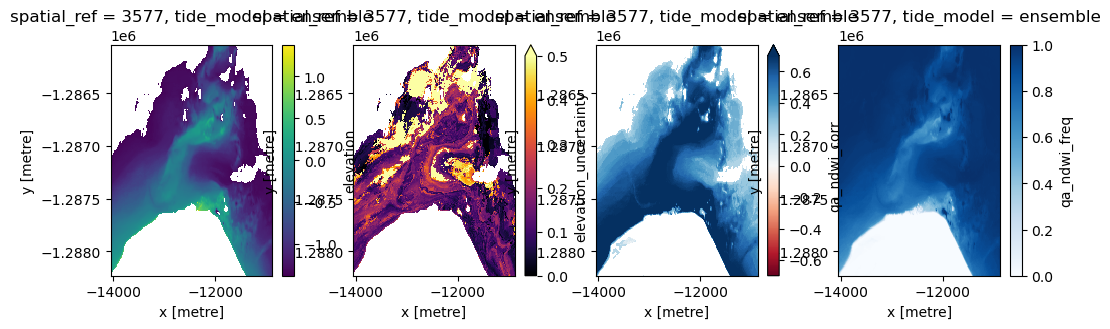

In [19]:
fix, axes = plt.subplots(1, 4, figsize=(12, 3))
ds.elevation.plot.imshow(cmap="viridis", ax=axes[0])
ds.elevation_uncertainty.plot.imshow(cmap="inferno", vmin=0, vmax=0.5, ax=axes[1])
ds.qa_ndwi_corr.plot.imshow(cmap="RdBu", vmin=-0.7, vmax=0.7, ax=axes[2])
ds.qa_ndwi_freq.plot.imshow(cmap="Blues", vmin=0, vmax=1, ax=axes[3])

In [20]:
ds.elevation.odc.explore()

### Export to GeoTIFF files

In [21]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

## Close Dask client

In [22]:
client.close()